# Import packages

In [23]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
import openai

In [24]:
# %load_ext autoreload
# %autoreload 2

import LLM_Geo_Constants as constants
import helper
# import LLM_Geo_kernel.Solution as Solution

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# Case 4: Hospital_accessibility
task_name ='Hospital_accessibility'

TASK = r'''
For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map, also show the hospital.
'''

# TASK = r'Diplay the  zipcode area in South Carolina (SC) and SC hospital locations in a  map.'

DATA_LOCATIONS = [
r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, map projection is WGS1984.",
r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: latitude in 'POINT_X' column, longitude in 'POINT_Y' column.",          
]

  
save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-3.5-turbo"
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.direct_request_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and developer good at Python. 
Your task: Write a Python program to address the question or task: 
For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map, also show the hospital.
 
Location for data you may need: 1. SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, map projection is WGS1984.
2. SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: latitude in 'POINT_X' column, longitude in 'POINT_Y' column. 
Your reply needs to meet these requirements: 
 1. DO NOT change the given variable names and paths.
2. Put your reply into a Python code block(enclosed by ```python and ```), NO explanation or conversation outside the code block.
3. If using GeoPan

```python
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from geopy.distance import distance
from tqdm import tqdm

# File paths
sc_zip_boundary = "https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip"
sc_hospitals = "https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv"

# Read SC zipcode boundary shapefile
gdf_zip = gpd.read_file(sc_zip_boundary)

# Read SC hospitals csv
df_hospitals = pd.read_csv(sc_hospitals)

# Convert latitude and longitude of hospitals to Point geometry
geometry_hospitals = [Point(xy) for xy in zip(df_hospitals.POINT_X, df_hospitals.POINT_Y)]
gdf_hospitals = gpd.GeoDataFrame(df_hospitals, crs="EPSG:4326", geometry=geometry_hospitals)

# Convert both dataframes to the same CRS
gdf_zip = gdf_zip.to_crs("EPSG:3857")
gdf_hospitals = gdf_hospitals.to_crs("EPSG:3857")

# Function to compute closest distance from zipcode centroid to near

100%|██████████████████████████████████████████████████████████████████████████████| 424/424 [00:00<00:00, 1155.31it/s]


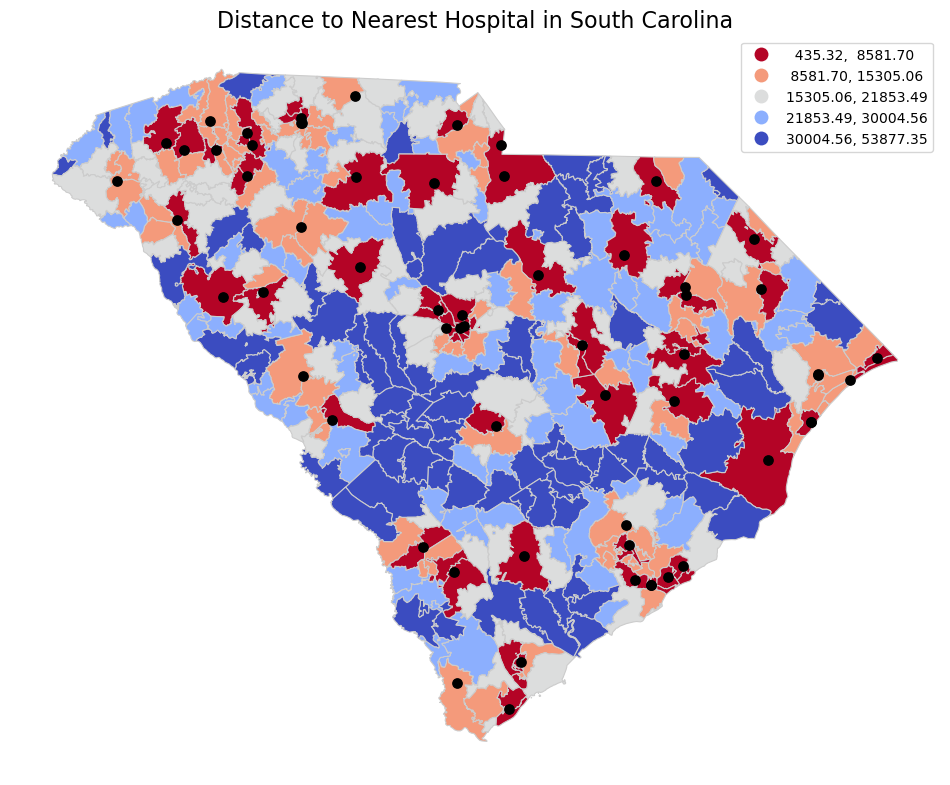

In [46]:
direct_request_LLM_response = solution.get_direct_request_LLM_response()
exec(solution.direct_request_code)